Created by Giorgos Patrikis and Joao Dossenna based on Tias Guns <Tias.Guns@kuleuven.be> digit recognizer,:

#### Handwritten Capital Letters Recognition
- Dataset = EMNIST
- Frameworks = PyTorch


### Necessary Imports

Recommended installation instructions:
https://pytorch.org/get-started/locally

This typically involves installing python3, python3-numpy, python3-matplotlib through an installer (anaconda) or system manager (apt), then installing torch and torchvision from python through conda or pip.

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from time import time

from cpmpy import *

### Download The Dataset & Define The Transforms

EMNIST contains letters of many different languages. It also contains non capital letters. So we have to
create a mask to only obtain the useful ones. The easiest split to obtain the data that we want is byclass and to those that we obtain we process them to all be normal looking characters, correctly aligned.

In [2]:
from torchvision import datasets, transforms
# Define a transform to normalize the data (effect: all values between -1 and 1)
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.EMNIST('.', split='byclass', download=True, train=True, transform=transform)
testset = datasets.EMNIST('.', split='byclass', download=True, train=False, transform=transform)

# Filter out non-uppercase letters from the training set
mask = (trainset.targets >= 10) & (trainset.targets <= 35)
trainset.data = trainset.data[mask].view(-1, 28, 28)
trainset.data = torch.rot90(trainset.data, k=3, dims=(1, 2))
trainset.targets = trainset.targets[mask] - 10


# Ensure the number of remaining images matches the original size of trainset.data
trainset.data = trainset.data[:124800]
trainset.targets = trainset.targets[:124800]

# Filter out non-uppercase letters from the test set
mask = (testset.targets >= 10) & (testset.targets <= 35)
testset.data = testset.data[mask].view(-1, 28, 28)
testset.data = torch.rot90(testset.data, k=3, dims=(1, 2))
testset.targets = testset.targets[mask] - 10

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
print("Data loaded.")

Data loaded.


### Showing a grid
We display a grid to check the quality of the dataset

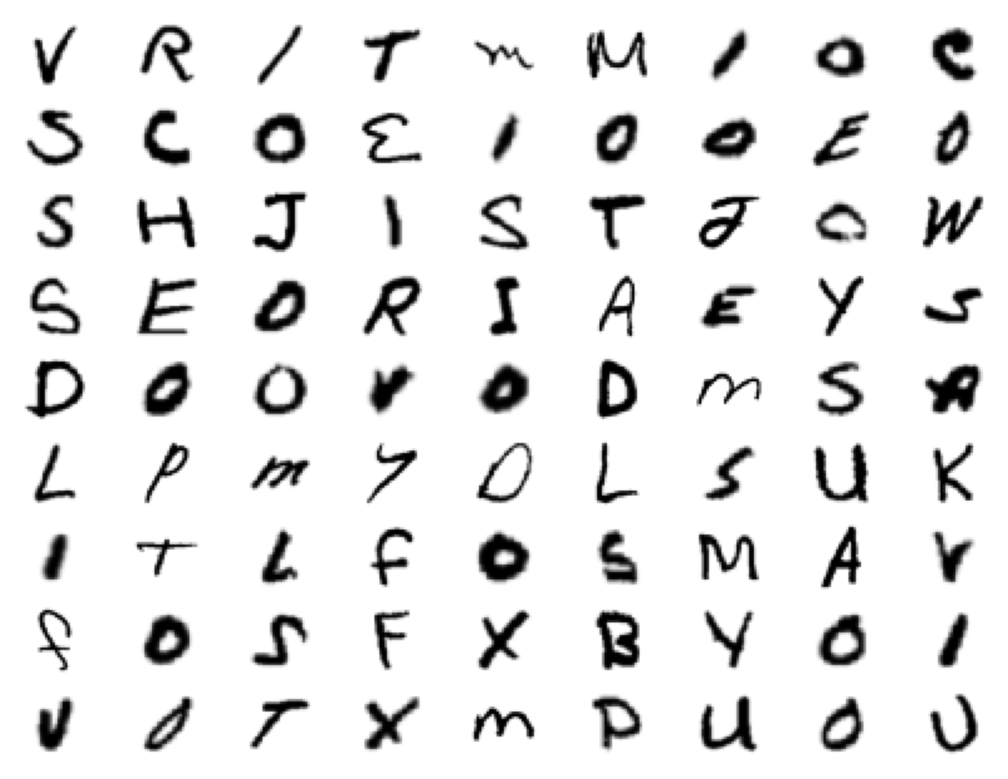

In [3]:
def show_grid_img(images):
    dim = 9
    figure = plt.figure()
    num_of_images = dim*dim
    for index in range(num_of_images):
        plt.subplot(dim, dim, index+1)
        plt.axis('off')
        # Transpose the image tensor so that the height and width dimensions are first and second
        plt.imshow(images[index].permute(1, 2, 0).numpy().squeeze(), cmap='gray_r')
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_grid_img(images)

### Defining The Neural Network

We will now define the __architecture__ of the neural network.

We define two architectures: a standard multi-layer perceptron network (the classical MLP) and a famous vision-specific architecture which is known to do well on MNIST: the LeNet architecture.

Building an architecture is done _declaratively_ in pytorch, very elegant as you will see.

### MLP architecture:
(this is the standard fully connected used-since-the-80's network)

The number of layers and its size are rather arbitrarily chosen.

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

### LeNet architecture

We now built a LeNet architecture, introduced by Yann LeCun in 1998. It consists of a convolutional layer followed by max-pooling, again a convolutional layer followed by max pooling, and then two fully connected layer followed by the LogSoftMax() output layer.


![](https://i.ibb.co/4tBDWxx/lenet.png)

The image above shows a graphical representation of the network, and for a an example input what the output of each layer could be.

For character recognition, due to the fact that we have more output features we want at the layers after the convolutions to
have more input and outputs to model better the differences


In [4]:
from Lenet import LeNetChar

print(LeNetChar())

LeNetChar(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=26, bias=True)
)


### Core Training Of Neural Network

Training is through stochastic gradient descent, with a given learning rate (lr) and momentum. Together with the number of epochs, the number of passes over the data, these determine the _hyperparameters_. Numbers from 0 to 25 are mapped to the characters A to Z.

In [ ]:
from torch import optim

def train_model(model, optimizer, epochs):
    # the stochastic gradient descent loop
    criterion = nn.NLLLoss() # negative log likelihood as loss
    time0 = time()
    print("Training starts, using", len(trainset), "training instances...")
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
    
            # Training pass
            optimizer.zero_grad()
        
            output = model(images)
            loss = criterion(output, labels)
        
            #This is where the model learns by backpropagating
            loss.backward()
        
            #And optimizes its weights here
            optimizer.step()
        
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    # model is now trained


# hyperparameters
model = LeNetChar()
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.9)
epochs = 50

train_model(model, optimizer, epochs)
torch.save(model.state_dict(), 'saved_models/characters_modelasda_nqweqeqn')

Training starts, using 124800 training instances...
Epoch 0 - Training loss: 0.9629449511032838
Epoch 1 - Training loss: 0.18613665013359143
Epoch 2 - Training loss: 0.13877285657593838
Epoch 3 - Training loss: 0.11641131953360179
Epoch 4 - Training loss: 0.10252789430033703
Epoch 5 - Training loss: 0.0916216676390897
Epoch 6 - Training loss: 0.08307066765446694
Epoch 7 - Training loss: 0.07738749558440386
Epoch 8 - Training loss: 0.07200631004304459
Epoch 9 - Training loss: 0.06638941027606145
Epoch 10 - Training loss: 0.061701500613051345
Epoch 11 - Training loss: 0.05883266524769939
Epoch 12 - Training loss: 0.05480390194660196


## Visualising the output

We use a helper function and then show both the input image, its output probability distribution and the maximum likelihood prediction.

tensor([[[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -0.9843, -0.9843, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -0.9765, -0.984

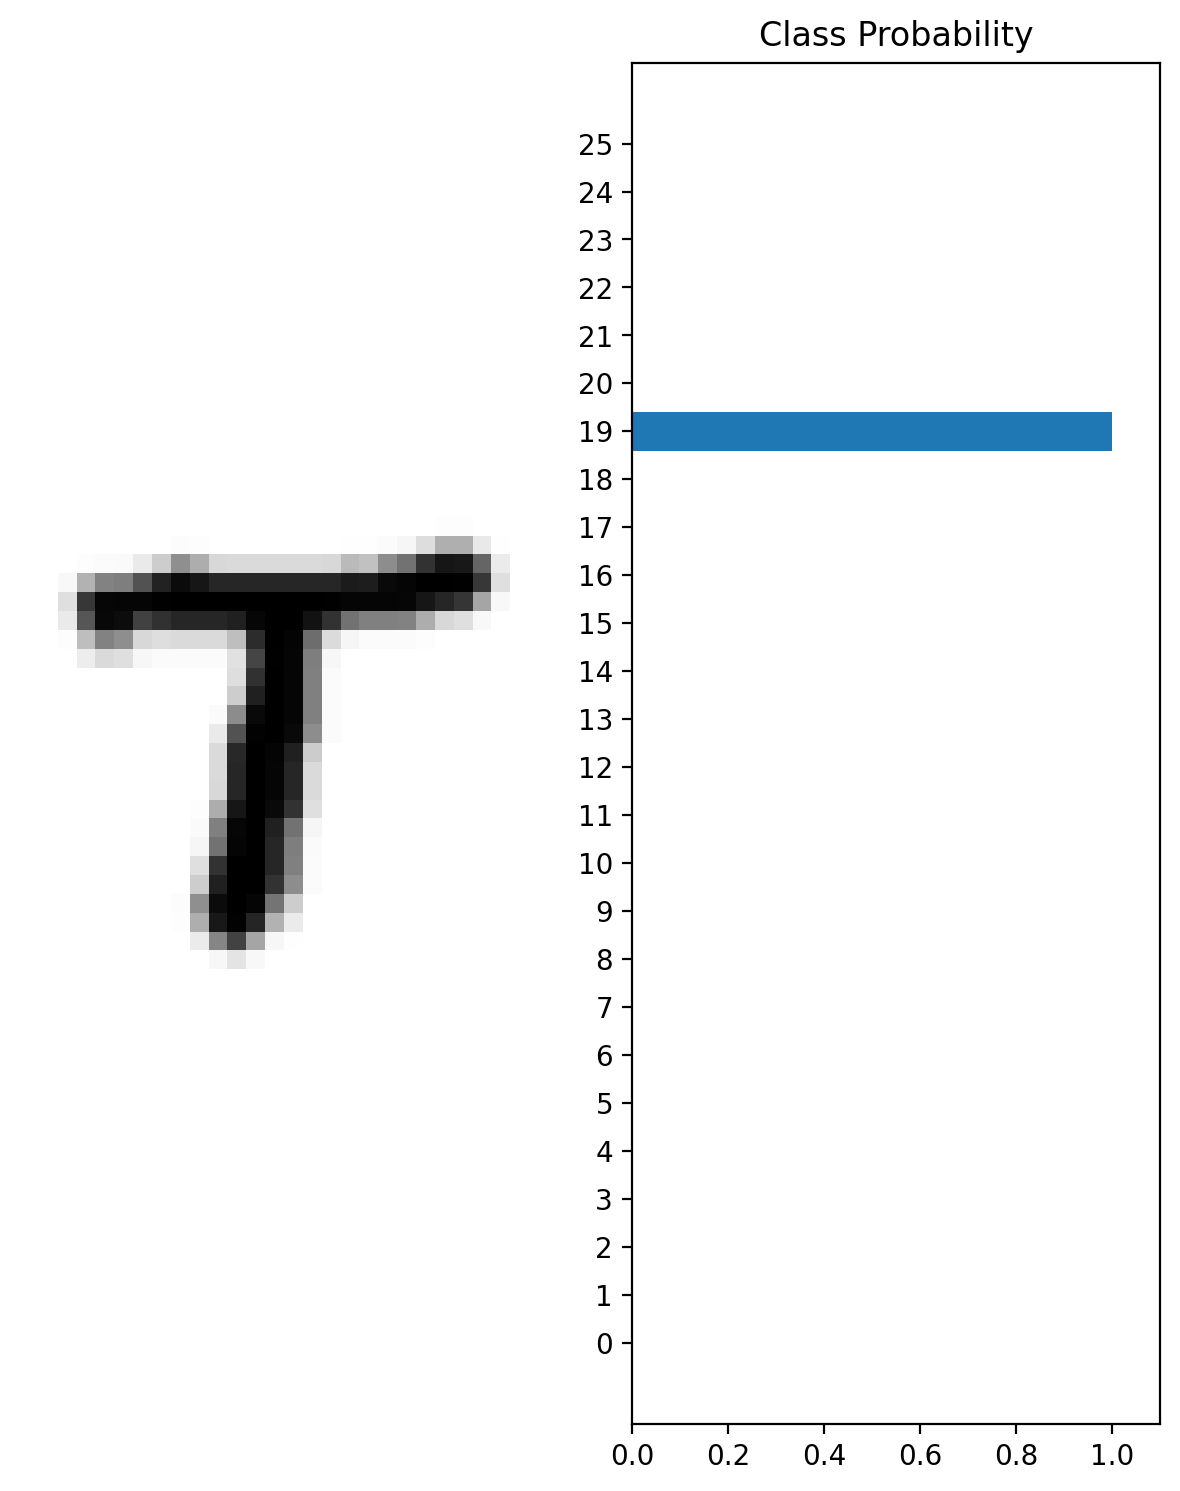

In [50]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze(), cmap='gray_r');
    ax1.axis('off')
    ax2.barh(np.arange(26), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(26))
    ax2.set_yticklabels(np.arange(26))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
def show_one_prediction(images, labels, i=0):
    # Turn off gradients to speed up this part
    img = images[i].unsqueeze(1) # classifier optimized for batches, make it a batch of 1
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    print(img)
    view_classify(img, ps)
    print("Predicted Digit =", probab.index(max(probab)), "\tActual =",int(labels[i]))

images, labels = next(iter(testloader))
show_one_prediction(images, labels)

You may notice a wrong prediction and varying class probabilities. That's because the network has _high training error_, measured by the training loss.

__Task for you__: Adjust the hyperparameters (and your patience) to train a better model!